Linear Regression RMSE on validation set: 0.1526
Best Random Forest params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best RF CV RMSE: 0.14116283994642753
5-Fold CV RMSE: 0.1439 ± 0.0197
XGBoost RMSE: 0.1437
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4083
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 166
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

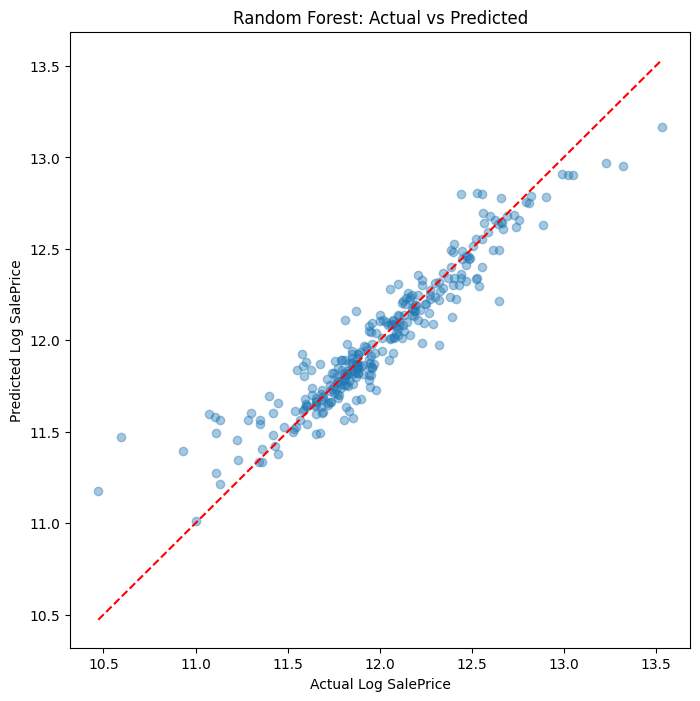

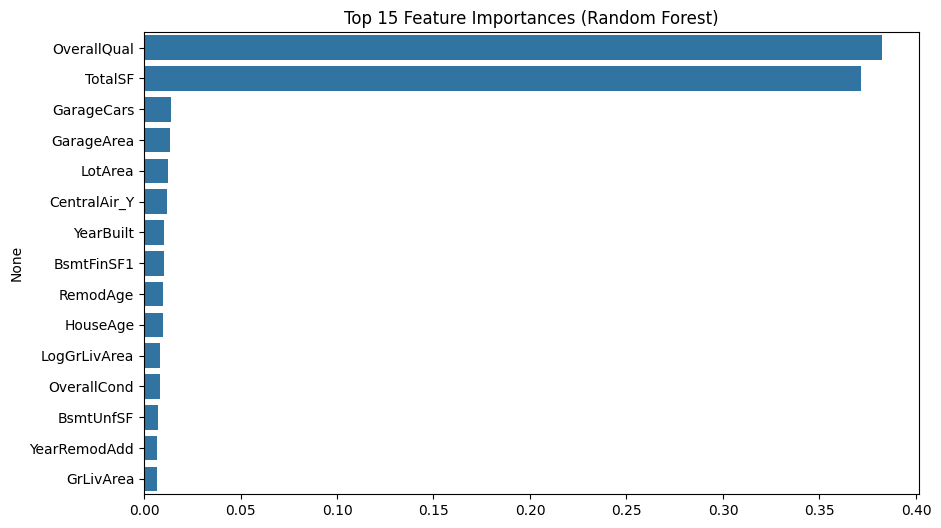

['models/best_rf_pipeline.pkl']

In [9]:
# notebooks/03_modeling.ipynb

# --------------------------
# 1. Import Libraries
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib


# --------------------------
# 2. Load Data
# --------------------------
train_df = pd.read_csv('D:/HousePricePredict/data/processed/train_feat.csv')


# --------------------------
# 3. Prepare Features and Target
# --------------------------
# Use log-transformed SalePrice target if exists, else create it on the fly
try:
    y = train_df['LogSalePrice']
except KeyError:
    y = np.log1p(train_df['SalePrice'])

X = train_df.drop(columns=['SalePrice', 'LogSalePrice'], errors='ignore')

# Split train-validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# --------------------------
# 4. Define Imputation + Model Pipelines
# --------------------------
imputer = SimpleImputer(strategy='median')

pipeline_lr = Pipeline([
    ('imputer', imputer),
    ('lr', LinearRegression())
])

pipeline_rf = Pipeline([
    ('imputer', imputer),
    ('rf', RandomForestRegressor(random_state=42))
])


# --------------------------
# 5. Train and Evaluate Linear Regression Baseline
# --------------------------
pipeline_lr.fit(X_train, y_train)
preds_lr = pipeline_lr.predict(X_valid)

rmse_lr = np.sqrt(mean_squared_error(y_valid, preds_lr))
print(f"Linear Regression RMSE on validation set: {rmse_lr:.4f}")


# --------------------------
# 6. Hyperparameter Tuning - Random Forest
# --------------------------
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

print('Best Random Forest params:', grid_search_rf.best_params_)
print('Best RF CV RMSE:', -grid_search_rf.best_score_)

best_rf_pipeline = grid_search_rf.best_estimator_


# --------------------------
# 7. Cross-Validation on Best RF Pipeline
# --------------------------
cv_scores = cross_val_score(
    best_rf_pipeline, X_train, y_train,
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
print(f'5-Fold CV RMSE: {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}')


# --------------------------
# 8. Train Advanced Gradient Boosting Models
# --------------------------

# Impute and fit XGBoost
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

xgb = XGBRegressor(random_state=42, n_estimators=200, max_depth=6, learning_rate=0.1)
xgb.fit(X_train_imputed, y_train)
preds_xgb = xgb.predict(X_valid_imputed)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, preds_xgb))
print(f'XGBoost RMSE: {rmse_xgb:.4f}')

# Impute and fit LightGBM with feature names to avoid warnings
X_train_df_imputed = pd.DataFrame(X_train_imputed, columns=X.columns)
X_valid_df_imputed = pd.DataFrame(X_valid_imputed, columns=X.columns)

lgbm = LGBMRegressor(random_state=42, n_estimators=200, max_depth=6, learning_rate=0.1)
lgbm.fit(X_train_df_imputed, y_train)
preds_lgbm = lgbm.predict(X_valid_df_imputed)
rmse_lgbm = np.sqrt(mean_squared_error(y_valid, preds_lgbm))
print(f'LightGBM RMSE: {rmse_lgbm:.4f}')

# Impute and fit CatBoost (silent mode)
catboost = CatBoostRegressor(random_state=42, iterations=200, depth=6, learning_rate=0.1, verbose=0)
catboost.fit(X_train_imputed, y_train)
preds_cat = catboost.predict(X_valid_imputed)
rmse_cat = np.sqrt(mean_squared_error(y_valid, preds_cat))
print(f'CatBoost RMSE: {rmse_cat:.4f}')


# --------------------------
# 9. Ensemble Predictions (Average of RF and XGBoost)
# --------------------------
ensemble_pred = (best_rf_pipeline.predict(X_valid) + preds_xgb) / 2
rmse_ensemble = np.sqrt(mean_squared_error(y_valid, ensemble_pred))
print(f'Ensemble RMSE (RF + XGBoost): {rmse_ensemble:.4f}')


# --------------------------
# 10. Visualize Predictions vs Actual (Random Forest)
# --------------------------
plt.figure(figsize=(8,8))
plt.scatter(y_valid, best_rf_pipeline.predict(X_valid), alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Actual Log SalePrice')
plt.ylabel('Predicted Log SalePrice')
plt.title('Random Forest: Actual vs Predicted')
plt.show()


# --------------------------
# 11. Feature Importance from Random Forest
# --------------------------
importances = best_rf_pipeline.named_steps['rf'].feature_importances_
features = X.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()


# --------------------------
# 12. Save Best Model for Future Use
# --------------------------
import os

model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_rf_pipeline, os.path.join(model_dir, 'best_rf_pipeline.pkl'))

joblib.dump(best_rf_pipeline, 'models/best_rf_pipeline.pkl')



In [15]:
import numpy as np
import pandas as pd
import os

# Load test features
test_df = pd.read_csv('D:/HousePricePredict/data/processed/test_feat.csv')

# Add missing columns with zeros
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0

# Align column order with training data
test_df = test_df[X.columns]

# Impute missing values in test data
X_test_imputed = imputer.transform(test_df)

# Predict using your best model (CatBoost here)
test_preds_log = catboost.predict(X_test_imputed)

# Revert log transform
test_preds = np.expm1(test_preds_log)

# Prepare submission file
if 'Id' in test_df.columns:
    submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': test_preds})
else:
    submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': test_preds})

# Set your existing submission folder path here
submission_folder = 'D:/HousePricePredict/results/submissions'

# Build complete file path
submission_path = os.path.join(submission_folder, 'final_submission.csv')

# Save submission without creating directory
submission.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")


Submission saved to D:/HousePricePredict/results/submissions\final_submission.csv
